In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import gc
import pandas as pd
import numpy as np
import torch
import datetime
from tqdm import tqdm_notebook
from torch import nn
from torchvision import transforms
from cnn_finetune import make_model
from sklearn.model_selection import StratifiedKFold

import model3 as M
import unet_parts
from dataset import SegmentationDataset, SegmentationInferenceDataset
from data import *
from util import *
from loss import FocalLoss, dice_loss
from lovasz_loss import lovasz_hinge_flat, lovasz_hinge

In [3]:
torch.cuda.is_available()
device = torch.device('cuda')

In [4]:
# Settings
# ========

# Target k in KFold
CV = 4

# Skip pretraining
skip_pretraining = False

In [5]:
train_df, val_df = get_dfs_fold(k=CV)

train_dataset = SegmentationDataset(train_df, size=(128, 128),
                                    use_depth_channels=True,
                                    with_aux_label=True,
                                    as_aux_label='coverage_class',
                                    use_augmentation=True)
val_dataset = SegmentationInferenceDataset(val_df, input_size=(128, 128),
                                           use_depth_channels=True, with_aux_label=False, with_gt=True)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=8, shuffle=False)
print('Loaded dataset and created loader')

Use augmentations
Loaded dataset and created loader


# Training

In [6]:
gc.collect()
torch.cuda.empty_cache()

model = M.UNetRes34AuxSCSE(n_classes=1, n_aux_classes=8)

if skip_pretraining:
    weight = torch.load(str(model_dir / f'unet_res34_hcauxscsev2_aug_kfold_cv{CV}_dict.model'))
    model.load_state_dict(weight, strict=False)
    print('Use pretrained weight')
    
model = model.to(device)

#optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
optimizer = torch.optim.Adam(model.parameters())

Loaded pretrained resnet weights


In [7]:
def criterion_phase1(logit, logit_aux, target_pixel, target_label):
    segmentation_loss = F.binary_cross_entropy_with_logits(logit.view(-1), target_pixel.view(-1), size_average=True)
    segmentation_dice_loss = dice_loss(logit, target_pixel)
    classification_loss = F.cross_entropy(logit_aux, target_label)
    
    return 0.5 * segmentation_loss + 0.5 * segmentation_dice_loss + 0.05 * classification_loss

In [8]:
def train_phase1(model, n_epoch, train_iter, val_iter):
    for epoch in range(n_epoch):
        model.train()
        
        gc.collect()
        torch.cuda.empty_cache()
        
        total_loss = 0
        total_size = 0
        
        for batch_idx, (data, target, label) in enumerate(train_iter):
            data, target, label = data.to(device), target.to(device), label.to(device)
            optimizer.zero_grad()
            
            # Forward
            logit, logit_aux = model(data)
            loss = criterion_phase1(logit, logit_aux, target, label)
            
            total_loss += loss.item()
            total_size += data.size(0)
            
            # Backward
            loss.backward()
            optimizer.step()
            
            if batch_idx % 50 == 0:
                now = datetime.datetime.now()
                print('[{}] Train Epoch: {} [{}/{} ({:.0f}%)]\tAverage loss: {:.6f}'.format(
                    now,
                    epoch, batch_idx * len(data), len(train_iter.dataset),
                    100. * batch_idx / len(train_iter), total_loss / total_size))
                
        gc.collect()
        torch.cuda.empty_cache()
        
        with torch.no_grad():
            iou = evaluate(model, val_iter, device=device, use_sigmoid=True, threshold=0.5)
        print('[{}] Train Epoch: {}\tIoU: {:.6f}'.format(now, epoch, iou))
    return model

In [9]:
if not skip_pretraining:
    model = train_phase1(model, 50, train_loader, val_loader)

D:\Users\ns\Anaconda3\envs\chainer\lib\site-packages\torch\nn\functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='elementwise_mean' instead.
  warnings.warn(warning.format(ret))


[2018-10-15 19:49:03.007970] Train Epoch: 0 [0/3204 (0%)]	Average loss: 0.051353
[2018-10-15 19:49:21.194740] Train Epoch: 0 [800/3204 (25%)]	Average loss: 0.037940
[2018-10-15 19:49:39.325080] Train Epoch: 0 [1600/3204 (50%)]	Average loss: 0.033374
[2018-10-15 19:49:57.485206] Train Epoch: 0 [2400/3204 (75%)]	Average loss: 0.031012
[2018-10-15 19:50:15.427745] Train Epoch: 0 [800/3204 (100%)]	Average loss: 0.029818
[2018-10-15 19:50:15.427745] Train Epoch: 0	IoU: 0.557915
[2018-10-15 19:50:25.647773] Train Epoch: 1 [0/3204 (0%)]	Average loss: 0.018667
[2018-10-15 19:50:43.765981] Train Epoch: 1 [800/3204 (25%)]	Average loss: 0.023714
[2018-10-15 19:51:01.904562] Train Epoch: 1 [1600/3204 (50%)]	Average loss: 0.023979
[2018-10-15 19:51:20.031799] Train Epoch: 1 [2400/3204 (75%)]	Average loss: 0.023235
[2018-10-15 19:51:37.941283] Train Epoch: 1 [800/3204 (100%)]	Average loss: 0.022908
[2018-10-15 19:51:37.941283] Train Epoch: 1	IoU: 0.587688
[2018-10-15 19:51:48.121552] Train Epoch: 2 

[2018-10-15 20:12:25.769215] Train Epoch: 17 [0/3204 (0%)]	Average loss: 0.005620
[2018-10-15 20:12:43.860848] Train Epoch: 17 [800/3204 (25%)]	Average loss: 0.009613
[2018-10-15 20:13:01.961097] Train Epoch: 17 [1600/3204 (50%)]	Average loss: 0.010720
[2018-10-15 20:13:20.057767] Train Epoch: 17 [2400/3204 (75%)]	Average loss: 0.010274
[2018-10-15 20:13:38.009540] Train Epoch: 17 [800/3204 (100%)]	Average loss: 0.010598
[2018-10-15 20:13:38.009540] Train Epoch: 17	IoU: 0.762437
[2018-10-15 20:13:48.196744] Train Epoch: 18 [0/3204 (0%)]	Average loss: 0.006386
[2018-10-15 20:14:06.310940] Train Epoch: 18 [800/3204 (25%)]	Average loss: 0.010623
[2018-10-15 20:14:24.428056] Train Epoch: 18 [1600/3204 (50%)]	Average loss: 0.010923
[2018-10-15 20:14:42.562426] Train Epoch: 18 [2400/3204 (75%)]	Average loss: 0.009894
[2018-10-15 20:15:00.485211] Train Epoch: 18 [800/3204 (100%)]	Average loss: 0.010511
[2018-10-15 20:15:00.485211] Train Epoch: 18	IoU: 0.752638
[2018-10-15 20:15:10.698775] Tra

[2018-10-15 20:35:37.899246] Train Epoch: 33	IoU: 0.758543
[2018-10-15 20:35:48.103335] Train Epoch: 34 [0/3204 (0%)]	Average loss: 0.005526
[2018-10-15 20:36:06.216240] Train Epoch: 34 [800/3204 (25%)]	Average loss: 0.006122
[2018-10-15 20:36:24.376313] Train Epoch: 34 [1600/3204 (50%)]	Average loss: 0.007288
[2018-10-15 20:36:42.470754] Train Epoch: 34 [2400/3204 (75%)]	Average loss: 0.007371
[2018-10-15 20:37:00.385668] Train Epoch: 34 [800/3204 (100%)]	Average loss: 0.007405
[2018-10-15 20:37:00.385668] Train Epoch: 34	IoU: 0.771231
[2018-10-15 20:37:10.547038] Train Epoch: 35 [0/3204 (0%)]	Average loss: 0.002624
[2018-10-15 20:37:28.698896] Train Epoch: 35 [800/3204 (25%)]	Average loss: 0.007281
[2018-10-15 20:37:46.862733] Train Epoch: 35 [1600/3204 (50%)]	Average loss: 0.007518
[2018-10-15 20:38:04.942599] Train Epoch: 35 [2400/3204 (75%)]	Average loss: 0.007222
[2018-10-15 20:38:22.875118] Train Epoch: 35 [800/3204 (100%)]	Average loss: 0.007068
[2018-10-15 20:38:22.875118] Tra

In [10]:
save_model(model, f'unet_res34_auxscse_aug_kfold_cv{CV}_phase1')

In [11]:
def criterion_phase2(logit, logit_aux, target_pixel, target_label):
    segmentation_loss = lovasz_hinge(logit.squeeze(), target_pixel.squeeze())
    classification_loss = F.cross_entropy(logit_aux, target_label)
    
    return segmentation_loss + 0.05 * classification_loss

In [12]:
def train_phase2(model, n_epoch, train_iter, val_iter):
    for epoch in range(n_epoch):
        model.train()
        
        gc.collect()
        torch.cuda.empty_cache()
        
        total_loss = 0
        total_size = 0
        
        for batch_idx, (data, target, label) in enumerate(train_iter):
            data, target, label = data.to(device), target.to(device), label.to(device)
            optimizer.zero_grad()
            
            # Forward
            logit, logit_aux = model(data)
            loss = criterion_phase2(logit, logit_aux, target, label)
            
            total_loss += loss.item()
            total_size += data.size(0)
            
            # Backward
            loss.backward()
            optimizer.step()
            
            if batch_idx % 50 == 0:
                now = datetime.datetime.now()
                print('[{}] Train Epoch: {} [{}/{} ({:.0f}%)]\tAverage loss: {:.6f}'.format(
                    now,
                    epoch, batch_idx * len(data), len(train_iter.dataset),
                    100. * batch_idx / len(train_iter), total_loss / total_size))
                
        gc.collect()
        torch.cuda.empty_cache()
        
        with torch.no_grad():
            iou = evaluate(model, val_iter, device=device, use_sigmoid=False, threshold=0.0)
        print('[{}] Train Epoch: {}\tIoU: {:.6f}'.format(now, epoch, iou))
    return model

In [13]:
model = train_phase2(model, 60, train_loader, val_loader)

[2018-10-15 20:57:48.918024] Train Epoch: 0 [0/3204 (0%)]	Average loss: 0.024976
[2018-10-15 20:58:08.890868] Train Epoch: 0 [800/3204 (25%)]	Average loss: 0.071496
[2018-10-15 20:58:28.888243] Train Epoch: 0 [1600/3204 (50%)]	Average loss: 0.070552
[2018-10-15 20:58:48.871643] Train Epoch: 0 [2400/3204 (75%)]	Average loss: 0.068731
[2018-10-15 20:59:08.614919] Train Epoch: 0 [800/3204 (100%)]	Average loss: 0.067923
[2018-10-15 20:59:08.614919] Train Epoch: 0	IoU: 0.760427
[2018-10-15 20:59:18.845893] Train Epoch: 1 [0/3204 (0%)]	Average loss: 0.069396
[2018-10-15 20:59:38.844199] Train Epoch: 1 [800/3204 (25%)]	Average loss: 0.055821
[2018-10-15 20:59:58.822826] Train Epoch: 1 [1600/3204 (50%)]	Average loss: 0.057108
[2018-10-15 21:00:18.809392] Train Epoch: 1 [2400/3204 (75%)]	Average loss: 0.056895
[2018-10-15 21:00:38.563146] Train Epoch: 1 [800/3204 (100%)]	Average loss: 0.054587
[2018-10-15 21:00:38.563146] Train Epoch: 1	IoU: 0.792337
[2018-10-15 21:00:48.775066] Train Epoch: 2 

[2018-10-15 21:23:18.077606] Train Epoch: 17 [0/3204 (0%)]	Average loss: 0.044802
[2018-10-15 21:23:38.059982] Train Epoch: 17 [800/3204 (25%)]	Average loss: 0.030111
[2018-10-15 21:23:58.046951] Train Epoch: 17 [1600/3204 (50%)]	Average loss: 0.030346
[2018-10-15 21:24:18.048404] Train Epoch: 17 [2400/3204 (75%)]	Average loss: 0.029799
[2018-10-15 21:24:37.791351] Train Epoch: 17 [800/3204 (100%)]	Average loss: 0.030300
[2018-10-15 21:24:37.791351] Train Epoch: 17	IoU: 0.805276
[2018-10-15 21:24:48.056591] Train Epoch: 18 [0/3204 (0%)]	Average loss: 0.037195
[2018-10-15 21:25:08.049303] Train Epoch: 18 [800/3204 (25%)]	Average loss: 0.030326
[2018-10-15 21:25:28.046383] Train Epoch: 18 [1600/3204 (50%)]	Average loss: 0.027858
[2018-10-15 21:25:48.040321] Train Epoch: 18 [2400/3204 (75%)]	Average loss: 0.028925
[2018-10-15 21:26:07.811074] Train Epoch: 18 [800/3204 (100%)]	Average loss: 0.028668
[2018-10-15 21:26:07.811074] Train Epoch: 18	IoU: 0.805905
[2018-10-15 21:26:18.000334] Tra

[2018-10-15 21:48:37.224791] Train Epoch: 33	IoU: 0.802513
[2018-10-15 21:48:47.415256] Train Epoch: 34 [0/3204 (0%)]	Average loss: 0.039259
[2018-10-15 21:49:07.388732] Train Epoch: 34 [800/3204 (25%)]	Average loss: 0.023219
[2018-10-15 21:49:27.343350] Train Epoch: 34 [1600/3204 (50%)]	Average loss: 0.023738
[2018-10-15 21:49:47.313875] Train Epoch: 34 [2400/3204 (75%)]	Average loss: 0.024963
[2018-10-15 21:50:07.063784] Train Epoch: 34 [800/3204 (100%)]	Average loss: 0.025460
[2018-10-15 21:50:07.063784] Train Epoch: 34	IoU: 0.812186
[2018-10-15 21:50:17.269992] Train Epoch: 35 [0/3204 (0%)]	Average loss: 0.024683
[2018-10-15 21:50:37.209798] Train Epoch: 35 [800/3204 (25%)]	Average loss: 0.022618
[2018-10-15 21:50:57.191652] Train Epoch: 35 [1600/3204 (50%)]	Average loss: 0.023899
[2018-10-15 21:51:17.162012] Train Epoch: 35 [2400/3204 (75%)]	Average loss: 0.024711
[2018-10-15 21:51:36.920332] Train Epoch: 35 [800/3204 (100%)]	Average loss: 0.025296
[2018-10-15 21:51:36.920332] Tra

[2018-10-15 22:14:06.114416] Train Epoch: 50 [800/3204 (100%)]	Average loss: 0.023726
[2018-10-15 22:14:06.114416] Train Epoch: 50	IoU: 0.777513
[2018-10-15 22:14:16.317795] Train Epoch: 51 [0/3204 (0%)]	Average loss: 0.014021
[2018-10-15 22:14:36.328756] Train Epoch: 51 [800/3204 (25%)]	Average loss: 0.021821
[2018-10-15 22:14:56.360172] Train Epoch: 51 [1600/3204 (50%)]	Average loss: 0.022776
[2018-10-15 22:15:16.378923] Train Epoch: 51 [2400/3204 (75%)]	Average loss: 0.021704
[2018-10-15 22:15:36.175779] Train Epoch: 51 [800/3204 (100%)]	Average loss: 0.021231
[2018-10-15 22:15:36.175779] Train Epoch: 51	IoU: 0.807286
[2018-10-15 22:15:46.357138] Train Epoch: 52 [0/3204 (0%)]	Average loss: 0.017498
[2018-10-15 22:16:06.422231] Train Epoch: 52 [800/3204 (25%)]	Average loss: 0.022703
[2018-10-15 22:16:26.400411] Train Epoch: 52 [1600/3204 (50%)]	Average loss: 0.023455
[2018-10-15 22:16:46.393855] Train Epoch: 52 [2400/3204 (75%)]	Average loss: 0.023877
[2018-10-15 22:17:06.204020] Tra

In [14]:
save_model(model, f'unet_res34_auxscse_aug_kfold_cv{CV}_phase2')

In [15]:
val_check_dataset = SegmentationInferenceDataset(val_df, input_size=(128, 128), with_gt=True, with_raw_input=True, use_depth_channels=True)
val_check_loader = torch.utils.data.DataLoader(val_check_dataset, batch_size=8, shuffle=False)
val_check_iter = iter(val_check_loader)

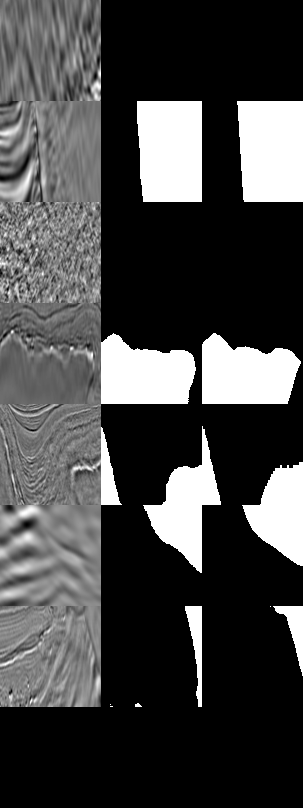

In [16]:
model.eval()
im, x, t = next(val_check_iter)
pred = predict(model, x, device, with_tta=True, use_sigmoid=True, threshold=0.5)
show_prediction(im, pred, t)

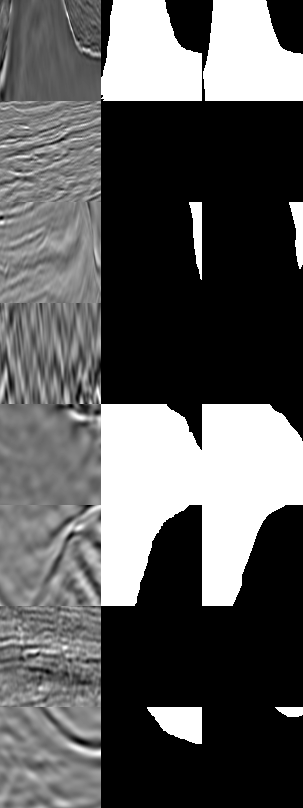

In [17]:
model.eval()
im, x, t = next(val_check_iter)
pred = predict(model, x, device, with_tta=True, use_sigmoid=False, threshold=0.0)
show_prediction(im, pred, t)

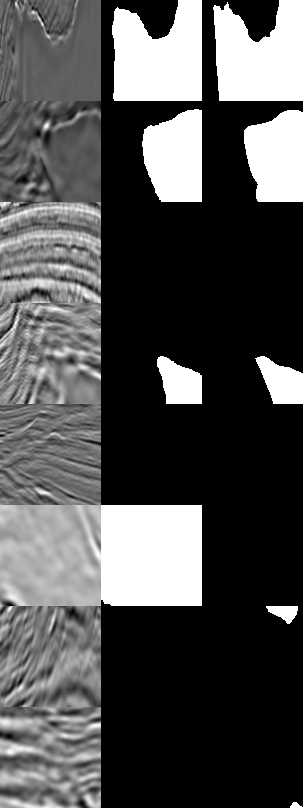

In [18]:
model.eval()
im, x, t = next(val_check_iter)
pred = predict(model, x, device, with_tta=True, use_sigmoid=False, threshold=0.0)
show_prediction(im, pred, t)

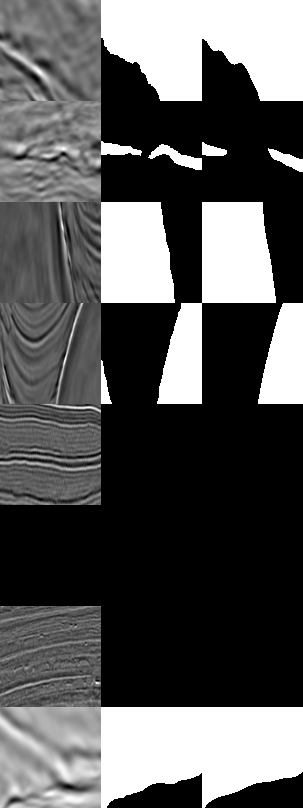

In [19]:
model.eval()
im, x, t = next(val_check_iter)
pred = predict(model, x, device, with_tta=True, use_sigmoid=False, threshold=0.0)
show_prediction(im, pred, t)